In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

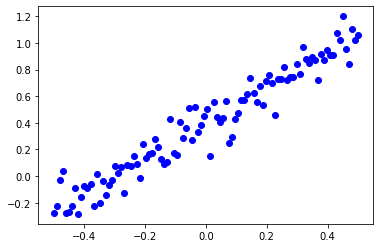

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[0.69995517]])
b: variable b([0.])
Operations on chainer.Variable: variable([[123.69996]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[0.69995517]] [[123.69996]]


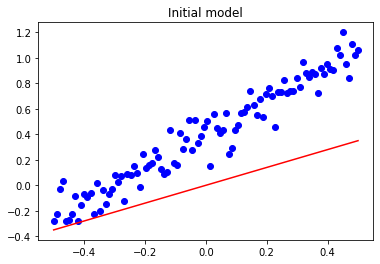

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.19968882)
dloss/dW [[-0.10441064]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.1717238)
Itr 25 loss: variable(0.00986945)
Itr 50 loss: variable(0.00986619)
Itr 75 loss: variable(0.00986619)


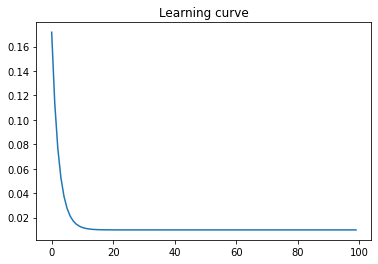

In [6]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []
alpha = 0.9

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    loss.backward()
    w_grad = model.W.grad[0]
    b_grad = model.b.grad[0]
    model.W.data[:] -= alpha * w_grad
    model.b.data[:] -= alpha * b_grad 
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


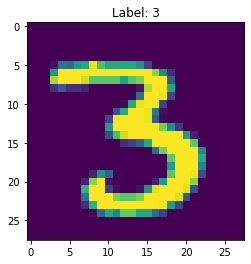

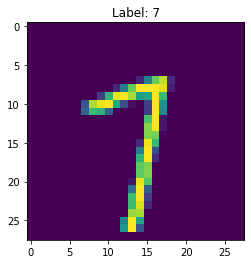

In [7]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [8]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

loss: 2.32802677154541; accuracy: 0.125
loss: 0.6307816481590272; accuracy: 0.85
loss: 0.5264815461635589; accuracy: 0.8575
loss: 0.38119828432798386; accuracy: 0.9075
loss: 0.3250014728307724; accuracy: 0.9025
loss: 0.3570395529270172; accuracy: 0.9025
loss: 0.28062633097171785; accuracy: 0.9275
loss: 0.355244520008564; accuracy: 0.9
loss: 0.3118065199255943; accuracy: 0.905
loss: 0.36723465979099273; accuracy: 0.8975
loss: 0.33034569591283797; accuracy: 0.9025
loss: 0.3324220165610313; accuracy: 0.9
loss: 0.3203451660275459; accuracy: 0.9
loss: 0.41206340968608857; accuracy: 0.89
loss: 0.24346892148256302; accuracy: 0.94
loss: 0.37133832305669784; accuracy: 0.8975
loss: 0.28611756503582003; accuracy: 0.9175
loss: 0.3197821915149689; accuracy: 0.92
loss: 0.3590422999858856; accuracy: 0.9025
loss: 0.2849988040328026; accuracy: 0.9225
loss: 0.3152556604146957; accuracy: 0.905
loss: 0.25199233561754225; accuracy: 0.915
loss: 0.3057148623466492; accuracy: 0.9175
loss: 0.2817613011598587; 

Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [9]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        
        # Pipe x through the nonlinear Relu Function from layer1 -> layer3
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        
        return x
        
        
run(MLP(200, 10))

loss: 2.2923548221588135; accuracy: 0.125
loss: 1.0563026475906372; accuracy: 0.61
loss: 0.8987607991695404; accuracy: 0.655
loss: 0.9187039732933044; accuracy: 0.65
loss: 0.920781067609787; accuracy: 0.645
loss: 0.7750776183605194; accuracy: 0.69
loss: 0.8293974232673645; accuracy: 0.6625
loss: 0.7267007774114609; accuracy: 0.7225
loss: 0.7685712337493896; accuracy: 0.695
loss: 0.7231303369998932; accuracy: 0.71
loss: 0.7423813474178315; accuracy: 0.6925
loss: 0.8332737755775451; accuracy: 0.665
loss: 0.8838796901702881; accuracy: 0.645
loss: 0.8685167098045349; accuracy: 0.6375
loss: 0.7594518339633942; accuracy: 0.6925
loss: 0.7931940007209778; accuracy: 0.6775
loss: 0.6859453773498535; accuracy: 0.725
loss: 0.698927356004715; accuracy: 0.715
loss: 0.707478905916214; accuracy: 0.7125
loss: 0.7642810213565826; accuracy: 0.69
loss: 0.6941393351554871; accuracy: 0.715
loss: 0.88243896484375; accuracy: 0.63
loss: 0.7286058473587036; accuracy: 0.6975
loss: 0.7224317228794098; accuracy: 0

Next you should try to implement logging test loss and see if the model is overfitting.

In [10]:
def plot_loss_accuracy(acc_train, acc_test, loss_train, loss_test):

    fig, axs = plt.subplots(1,2,figsize=(10,10))
    axs[0].plot(acc_train)
    axs[0].plot(acc_test)
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'test'])
    
    axs[1].plot(loss_train)
    axs[1].plot(loss_test)
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'test'])
    

In [13]:
def better_run(model, batchsize=16, num_epochs=2, train=train, test=test, shuffle_train=True, shuffle_test=False):
    
    # Initialite lists to capture test loss and accuracy
    accuracy_train, loss_train, accuracy_test, loss_test = [], [], [], []

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=shuffle_train)
        for itr, batch in enumerate(train_iter):
            # Get batch
            x_train = np.concatenate([datum[0][None, :] for datum in batch])
            y_train = np.array([datum[1] for datum in batch])
            
            # Logits
            z_train = model(x_train)
            
            # Loss
            l_train = F.softmax_cross_entropy(z_train, y_train)
            model.cleargrads()
            
            # Backprop
            l_train.backward()
            
            # Update
            optimizer.update()
            
            # calculate stats
            stats["loss_train"].append(float(l_train.data))
            stats["accuracy_train"].append(float((z_train.data.argmax(1) == y_train).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=shuffle_test)
                # *** YOUR CODE implement logging of stats on test set ***
                print("; ".join("Epoch:%s %s: %s" % (epoch, k, np.mean(vs)) for k, vs in stats.items()))
                for test_itr, test_batch in enumerate(test_iter):
                    x_test = np.concatenate([datum[0][None, :] for datum in test_batch])
                    y_test = np.array([datum[1] for datum in test_batch])
                    z_test = model(x_test) # logits
                    l_test = F.softmax_cross_entropy(z_test, y_test)
                    stats["loss_test"].append(float(l_test.data))
                    stats["accuracy_test"].append(float((z_test.data.argmax(1) == y_test).sum() / batchsize))
                
                # Capture training and test params for plotting
                accuracy_train.append(np.mean(stats["accuracy_train"]))
                accuracy_test.append(np.mean(stats["accuracy_test"]))
                loss_train.append(np.mean(stats["loss_train"]))
                loss_test.append(np.mean(stats["loss_test"]))
    return accuracy_train, accuracy_test, loss_train, loss_test

accuracy_train, accuracy_test, loss_train, loss_test = better_run(MLP(200, 10))

Epoch:0 loss_train: 2.327183723449707; Epoch:0 accuracy_train: 0.0625
Epoch:0 loss_train: 0.6652277779579162; Epoch:0 accuracy_train: 0.765; Epoch:0 loss_test: 2.3052750778198243; Epoch:0 accuracy_test: 0.13
Epoch:0 loss_train: 0.7247308886051178; Epoch:0 accuracy_train: 0.745; Epoch:0 loss_test: 0.8666632032394409; Epoch:0 accuracy_test: 0.705
Epoch:0 loss_train: 0.6940040957927703; Epoch:0 accuracy_train: 0.7425; Epoch:0 loss_test: 0.7791976749897003; Epoch:0 accuracy_test: 0.735
Epoch:0 loss_train: 0.6354272413253784; Epoch:0 accuracy_train: 0.7625; Epoch:0 loss_test: 0.7525062727928161; Epoch:0 accuracy_test: 0.7375
Epoch:0 loss_train: 0.6273945862054825; Epoch:0 accuracy_train: 0.76; Epoch:0 loss_test: 0.7414974391460418; Epoch:0 accuracy_test: 0.7375
Epoch:0 loss_train: 0.6073107385635376; Epoch:0 accuracy_train: 0.77; Epoch:0 loss_test: 0.7450817620754242; Epoch:0 accuracy_test: 0.735
Epoch:0 loss_train: 0.5385857987403869; Epoch:0 accuracy_train: 0.7875; Epoch:0 loss_test: 0.73

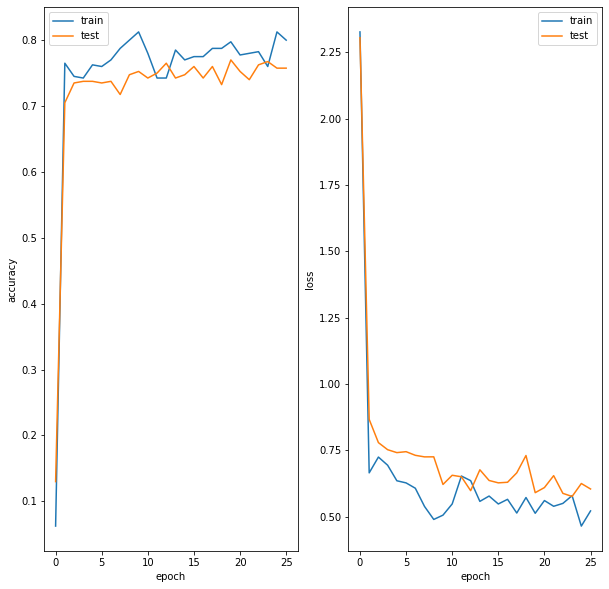

In [14]:
plot_loss_accuracy(accuracy_train, accuracy_test, loss_train, loss_test)

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc

### ConvNet
- https://docs.chainer.org/en/stable/examples/cnn.html

In [15]:
from chainer import Chain

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=8, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(
                in_channels=8, out_channels=16, ksize=5, stride=1)
            self.fc3 = L.Linear(None, 10)
            
    def __call__(self, x):
        x = x.reshape(x.shape[0],1,28,28)
        x = F.relu(self.conv1(x))
        x = F.max_pooling_2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        return F.softmax(self.fc3(x))
    
acc_conv_train, acc_conv_test, loss_conv_train, loss_conv_test = better_run(ConvNet())


Epoch:0 loss_train: 2.3032114505767822; Epoch:0 accuracy_train: 0.125
Epoch:0 loss_train: 1.6792831563949584; Epoch:0 accuracy_train: 0.79; Epoch:0 loss_test: 2.2967434215545652; Epoch:0 accuracy_test: 0.1475
Epoch:0 loss_train: 1.5643548059463501; Epoch:0 accuracy_train: 0.9075; Epoch:0 loss_test: 1.7206650733947755; Epoch:0 accuracy_test: 0.75
Epoch:0 loss_train: 1.53308274269104; Epoch:0 accuracy_train: 0.9275; Epoch:0 loss_test: 1.625222420692444; Epoch:0 accuracy_test: 0.84
Epoch:0 loss_train: 1.5259274101257325; Epoch:0 accuracy_train: 0.935; Epoch:0 loss_test: 1.5735571050643922; Epoch:0 accuracy_test: 0.8875
Epoch:0 loss_train: 1.5259590816497803; Epoch:0 accuracy_train: 0.9375; Epoch:0 loss_test: 1.552714104652405; Epoch:0 accuracy_test: 0.9125
Epoch:0 loss_train: 1.5137015438079835; Epoch:0 accuracy_train: 0.9475; Epoch:0 loss_test: 1.5342559289932252; Epoch:0 accuracy_test: 0.9325
Epoch:0 loss_train: 1.514407114982605; Epoch:0 accuracy_train: 0.9475; Epoch:0 loss_test: 1.529

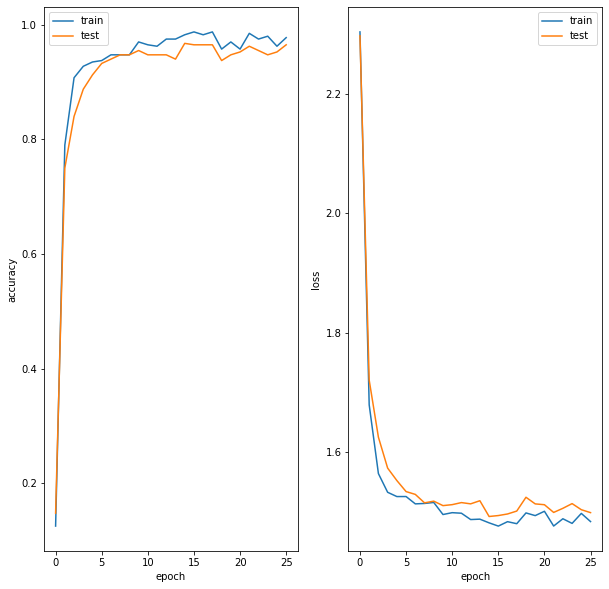

In [16]:
plot_loss_accuracy(acc_conv_train, acc_conv_test, loss_conv_train, loss_conv_test)

A simple CovNet converges a lot faster compared to the simple MLP since after the first epoch it has ~95% test accuracy compared to the ~70% of the MLP. It does not necessariliy prevent overfitting though beats the MLP in terms of performance and final test accurracy.

### LeNet5

In [17]:
class LeNet5(Chain):
    def __init__(self):
        super(LeNet5, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=1, out_channels=6, ksize=5, stride=1)
            self.conv2 = L.Convolution2D(
                in_channels=6, out_channels=16, ksize=5, stride=1)
            self.conv3 = L.Convolution2D(
                in_channels=16, out_channels=120, ksize=4, stride=1)
            self.fc4 = L.Linear(None, 84)
            self.fc5 = L.Linear(84, 10)

    def forward(self, x):
        x = x.reshape(x.shape[0],1,28,28)
        h = F.sigmoid(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.sigmoid(self.conv3(h))
        h = F.sigmoid(self.fc4(h))
        if chainer.config.train:
            return self.fc5(h)
        return F.softmax(self.fc5(h))

acc_lee_train, acc_lee_test, loss_lee_train, loss_lee_test = better_run(LeNet5())

Epoch:0 loss_train: 2.4607443809509277; Epoch:0 accuracy_train: 0.125
Epoch:0 loss_train: 2.2291412448883055; Epoch:0 accuracy_train: 0.3175; Epoch:0 loss_test: 2.3851939868927; Epoch:0 accuracy_test: 0.1025
Epoch:0 loss_train: 0.831272325515747; Epoch:0 accuracy_train: 0.81; Epoch:0 loss_test: 2.183686227798462; Epoch:0 accuracy_test: 0.385
Epoch:0 loss_train: 0.39910812079906466; Epoch:0 accuracy_train: 0.9125; Epoch:0 loss_test: 0.8329007124900818; Epoch:0 accuracy_test: 0.8
Epoch:0 loss_train: 0.23742483496665956; Epoch:0 accuracy_train: 0.9475; Epoch:0 loss_test: 0.5384301567077636; Epoch:0 accuracy_test: 0.8375
Epoch:0 loss_train: 0.2253379064798355; Epoch:0 accuracy_train: 0.9375; Epoch:0 loss_test: 0.3551136201620102; Epoch:0 accuracy_test: 0.9025
Epoch:0 loss_train: 0.19824693381786346; Epoch:0 accuracy_train: 0.9475; Epoch:0 loss_test: 0.3124334722757339; Epoch:0 accuracy_test: 0.8925
Epoch:0 loss_train: 0.2291747236251831; Epoch:0 accuracy_train: 0.9275; Epoch:0 loss_test: 0

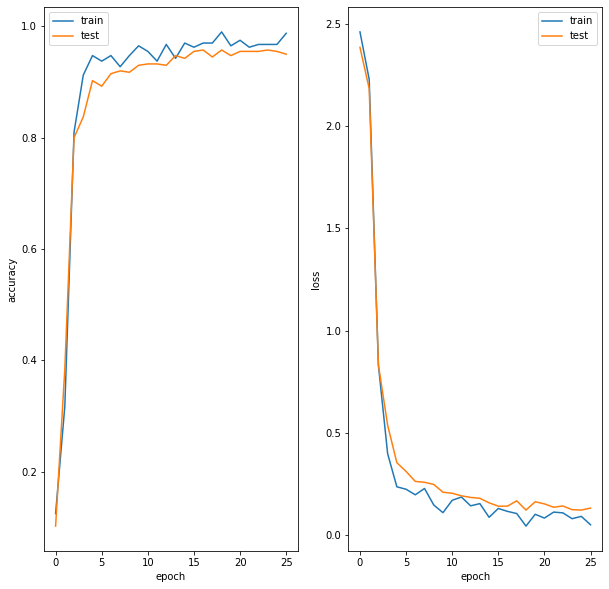

In [18]:
plot_loss_accuracy(acc_lee_train, acc_lee_test, loss_lee_train, loss_lee_test)

The slightly bigger LeeNet is comparable to the smaller ConvNet in terms of performance. The test accuracy curve shows a bend in the slope which might be an indicator that the model is starting to overfit.


### Correlated gradients

- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc

In [29]:
train, test = chainer.datasets.get_mnist()

# Sort indices
train_idx_sorted = np.argsort(train._datasets[1])
test_idx_sorted = np.argsort(test._datasets[1])

train._datasets = [train._datasets[0][train_idx_sorted],train._datasets[1][train_idx_sorted]]

acc_mlp_train_sorted, acc_mlp_test, loss_mlp_train, loss_mlp_test = better_run(MLP(200,10), train=train, test=test, shuffle_train=False)

Epoch:0 loss_train: 2.345451831817627; Epoch:0 accuracy_train: 0.0
Epoch:0 loss_train: 1.0442733764648437e-06; Epoch:0 accuracy_train: 1.0; Epoch:0 loss_test: 2.2915484142303466; Epoch:0 accuracy_test: 0.1725
Epoch:0 loss_train: 1.0728836059570313e-07; Epoch:0 accuracy_train: 1.0; Epoch:0 loss_test: 14.420374870300293; Epoch:0 accuracy_test: 0.1075
Epoch:0 loss_train: 2.3025851249694824; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 25.506572875976563; Epoch:0 accuracy_test: 0.1225
Epoch:0 loss_train: 2.3025851249694824; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.302591562271118; Epoch:0 accuracy_test: 0.1075
Epoch:0 loss_train: 2.3025851249694824; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.302591562271118; Epoch:0 accuracy_test: 0.1075
Epoch:0 loss_train: 2.3025851249694824; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.3025851249694824; Epoch:0 accuracy_test: 0.1075
Epoch:0 loss_train: 2.3025851249694824; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.302585124

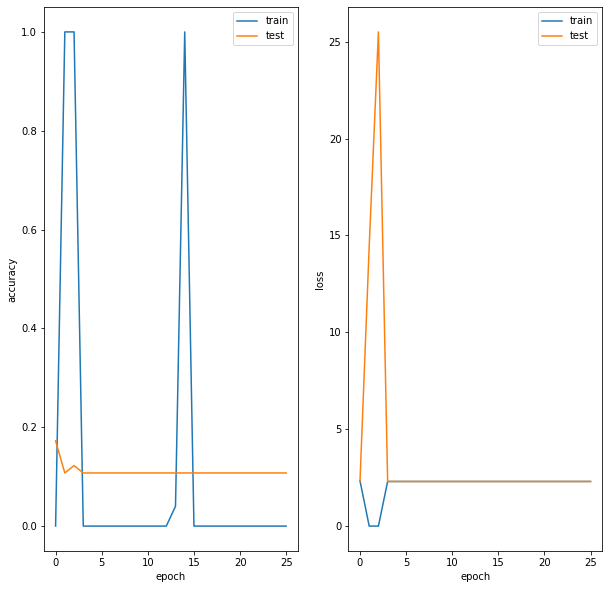

In [30]:
plot_loss_accuracy(acc_mlp_train_sorted, acc_mlp_test, loss_mlp_train, loss_mlp_test)

Correlated gradients exhibit no learning, the accuracy on the test set stays constantly ~10% which is random guessing.

### Correlated Gradients with ConvNet

In [31]:
train, test = chainer.datasets.get_mnist()

# Sort indices
train_idx_sorted = np.argsort(train._datasets[1])

# Build the sorted training set
train._datasets = [train._datasets[0][train_idx_sorted], train._datasets[1][train_idx_sorted]]
    
acc_conv_train_sorted, acc_conv_test, loss_conv_train_sorted, loss_conv_test = better_run(ConvNet(), train = train, test = test, shuffle_train=False)

Epoch:0 loss_train: 2.33821177482605; Epoch:0 accuracy_train: 0.0
Epoch:0 loss_train: 1.4611501693725586; Epoch:0 accuracy_train: 1.0; Epoch:0 loss_test: 2.3045121097564696; Epoch:0 accuracy_test: 0.065
Epoch:0 loss_train: 2.461149959564209; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.3536501693725587; Epoch:0 accuracy_test: 0.1075
Epoch:0 loss_train: 2.4611501693725586; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.3536501693725587; Epoch:0 accuracy_test: 0.1075
Epoch:0 loss_train: 2.4611501693725586; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.3536501693725587; Epoch:0 accuracy_test: 0.1075
Epoch:0 loss_train: 2.4611501693725586; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.3536501693725587; Epoch:0 accuracy_test: 0.1075
Epoch:0 loss_train: 2.4611501693725586; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.3536501693725587; Epoch:0 accuracy_test: 0.1075
Epoch:0 loss_train: 2.4611501693725586; Epoch:0 accuracy_train: 0.0; Epoch:0 loss_test: 2.3536501693725587; 

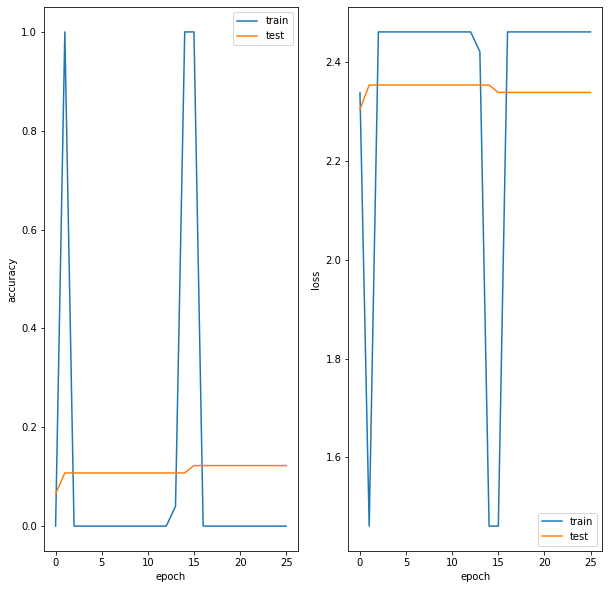

In [32]:
plot_loss_accuracy(acc_conv_train_sorted, acc_conv_test, loss_conv_train_sorted, loss_conv_test)

Using a ConvNet also does not exhibit any learning when correlating the gradients.